In [57]:
%matplotlib inline
import sys
from simulation_toykit_sources import *

sys.path.append('../virtuallab/tools')
from common import *

def get_ipynb_dir():
    return "../virtuallab/pynb/sources/gaussian_wave/"

notebook_dir = get_ipynb_dir()
degree       = np.pi/180
wavelength   = 0.5
start  = [-5, -5] # 'um'
end    = [5, 5]
shape  = [100, 100]

step   = [(b-a)/(N-1) for a,b,N in zip(start, end, shape)]
meta   = {
    "dx" : step[0] * 1e-3, # set display unit to 'mm'
    "dy" : step[1] * 1e-3,
    "nx" : shape[0],
    "ny" : shape[1]
}

display_pos = [[0,0], [0,1], [1, 0], [1, 1]]
# display_pos = [[0,0], [0,1], [0,2], [0,3]]

In [58]:
w0 = 2

x = np.linspace(-shape[0]//2, shape[0] - 1 - shape[0]//2, shape[0])
y = np.linspace(-shape[1]//2, shape[1] - 1 - shape[1]//2, shape[1])
x *= step[0]
y *= step[1]
x[shape[0]//2] = 0
y[shape[1]//2] = 0
X, Y = np.meshgrid(x, y)

def q_z(z, zr):
    return z +1j*zr

def beam_divergence(M_2, k, w0):
    return M_2 * 2/(k * w0)

def rayleigh_distance(M_2, k, w0):
    return w0/beam_divergence(M_2, k, w0)

def gouy_angle(z, M_2, k, w0):
    # 这里的 $z_R$ 必须小心，它是该模式对应的基模的瑞利距离
    return M_2 * np.arctan2(rayleigh_distance(1, k, w0), z)


def wz(z, M_2, k, w0):
    return w0 * np.sqrt(1 + (z/rayleigh_distance(M_2, k, w0))**2)

def wavefront_curvature(z, M_2, k, w0):
    return z/(z**2 + rayleigh_distance( M_2, k, w0)**2)

from scipy.special import genlaguerre
def laguerre_gaussian_normalized(X, Y, w0, z, wavelength, p, l, version = 1):
    k = 2 * np.pi / wavelength
    N = 2*p + abs(l) # N = l + m
    M_2 = (N + 1)
    r2 = X**2 + Y**2
    theta = np.arctan2(Y, X)
    if 0 == version:
        Lpl = genlaguerre(p, abs(l))(2 * r2/(wz(z, M_2, k, w0)**2))
        U = Lpl * np.exp(-r2/(wz(z, M_2, k, w0)**2)) * np.exp(-1j*k*r2*wavefront_curvature(z, M_2, k, w0)/2) * np.exp(-1j * (l * theta + gouy_angle(z, M_2, k, w0)))
    elif 1 == version:
        reduction_ratio = np.sqrt(1 + (z / rayleigh_distance(M_2, k, w0))**2)
        r2_scalaed = r2 * M_2 / reduction_ratio / reduction_ratio

        Lpl = genlaguerre(p, abs(l))(2 * r2_scalaed /(wz(z, 1, k, w0)**2))
        U = np.sqrt(r2_scalaed)**abs(l) * Lpl * np.exp(- r2_scalaed /(wz(z, 1, k, w0)**2)) * \
            np.exp(1j * (k * z + k*r2*wavefront_curvature(z, M_2, k, w0) /  2 + l * theta - gouy_angle(z, M_2, k, w0)))

    U /= np.max(np.abs(U))
    return U, wz(z, 1, k, w0), rayleigh_distance(M_2, k, w0), beam_divergence(M_2, k, w0), gouy_angle(z, M_2, k, w0)


def find_local_extrema_np(data_list):
    """
    找出列表中符合定义的极小值和极大值，支持 Python list, tuple 和 NumPy ndarray。

    定义:
    - 极小值 (Local Minimum): a > b 和 b < c
    - 极大值 (Local Maximum): a < b 和 b > c

    参数:
        data_list (list/tuple/np.ndarray): 包含数值的输入数据。

    返回:
        dict: 包含 'minima' (极小值及其索引) 和 'maxima' (极大值及其索引) 的字典。
    """
    # 统一转换为 NumPy 数组，以便于处理
    data_array = np.asarray(data_list)
    
    # 列表长度至少需要为 3 才能找到极值
    if data_array.size < 3:
        return {"minima": [], "maxima": []}

    local_minima = []
    local_maxima = []
    n = data_array.size

    # 使用 NumPy 数组切片来获取相邻的三个元素序列，
    # 这样可以一次性比较所有内部元素，速度更快 (向量化操作)。
    
    # a: 前一个值 (索引 0 到 n-3)
    a = data_array[:-2] 
    # b: 当前值 (索引 1 到 n-2) - 这是我们寻找的极值点
    b = data_array[1:-1]
    # c: 后一个值 (索引 2 到 n-1)
    c = data_array[2:]
    
    # 内部元素的原始索引从 1 开始
    internal_indices = np.arange(1, n - 1) 

    # --- 寻找极小值 (a > b 且 b < c) ---
    # 使用 & (逻辑与) 结合两个布尔条件
    minima_condition = (a > b) & (b < c)
    
    # 找出符合条件的 b 的索引（相对于 internal_indices 数组）
    minima_relative_indices = np.where(minima_condition)[0]
    
    # 将相对索引映射回原始数据数组的索引
    minima_indices = internal_indices[minima_relative_indices]
    minima_values = b[minima_relative_indices]
    
    for idx, val in zip(minima_indices, minima_values):
        local_minima.append({"index": int(idx), "value": float(val)})

    # --- 寻找极大值 (a < b 且 b > c) ---
    maxima_condition = ((a+1e-6) < b) & (b > (c + 1e-6))
    
    maxima_relative_indices = np.where(maxima_condition)[0]
    
    maxima_indices = internal_indices[maxima_relative_indices]
    maxima_values = b[maxima_relative_indices]

    for idx, val in zip(maxima_indices, maxima_values):
        local_maxima.append({"index": int(idx), "value": float(val)})

    return {
        "minima": local_minima,
        "maxima": local_maxima
    }

patch phase = [-142.9122898816861, 32.05125905961825, -180.0, 32.160121040693106, -8.147459846760306, 16.730367617820036, -120.65345249864875, -12.862902500686982] degree
(p=3, l=3, z=1.3963)
w_z=2.0030842034779055 um, rz=2.5132741228718345 um, divergence=45.594532639052005 degree, gouy=148.20086702506075 degree.


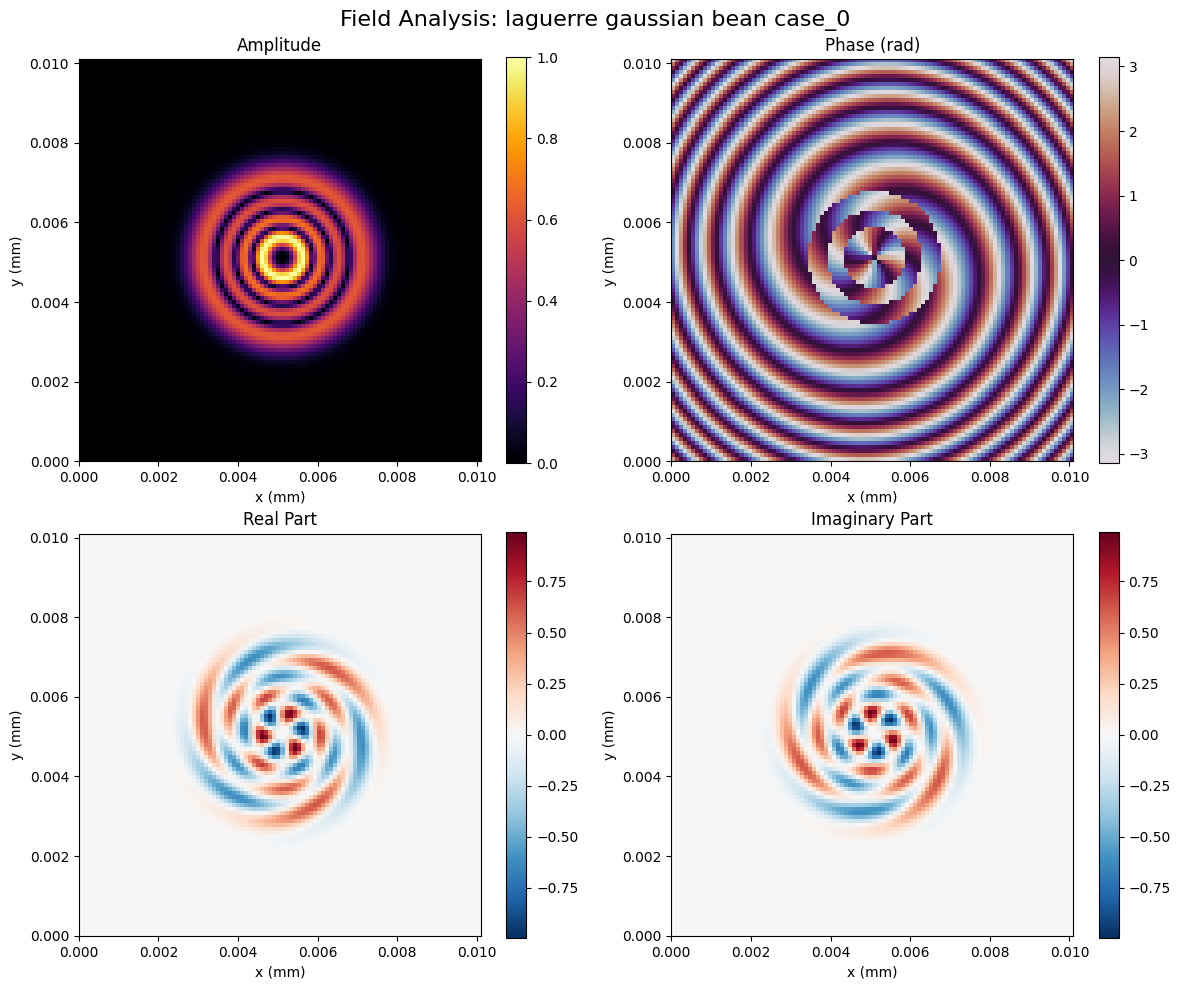

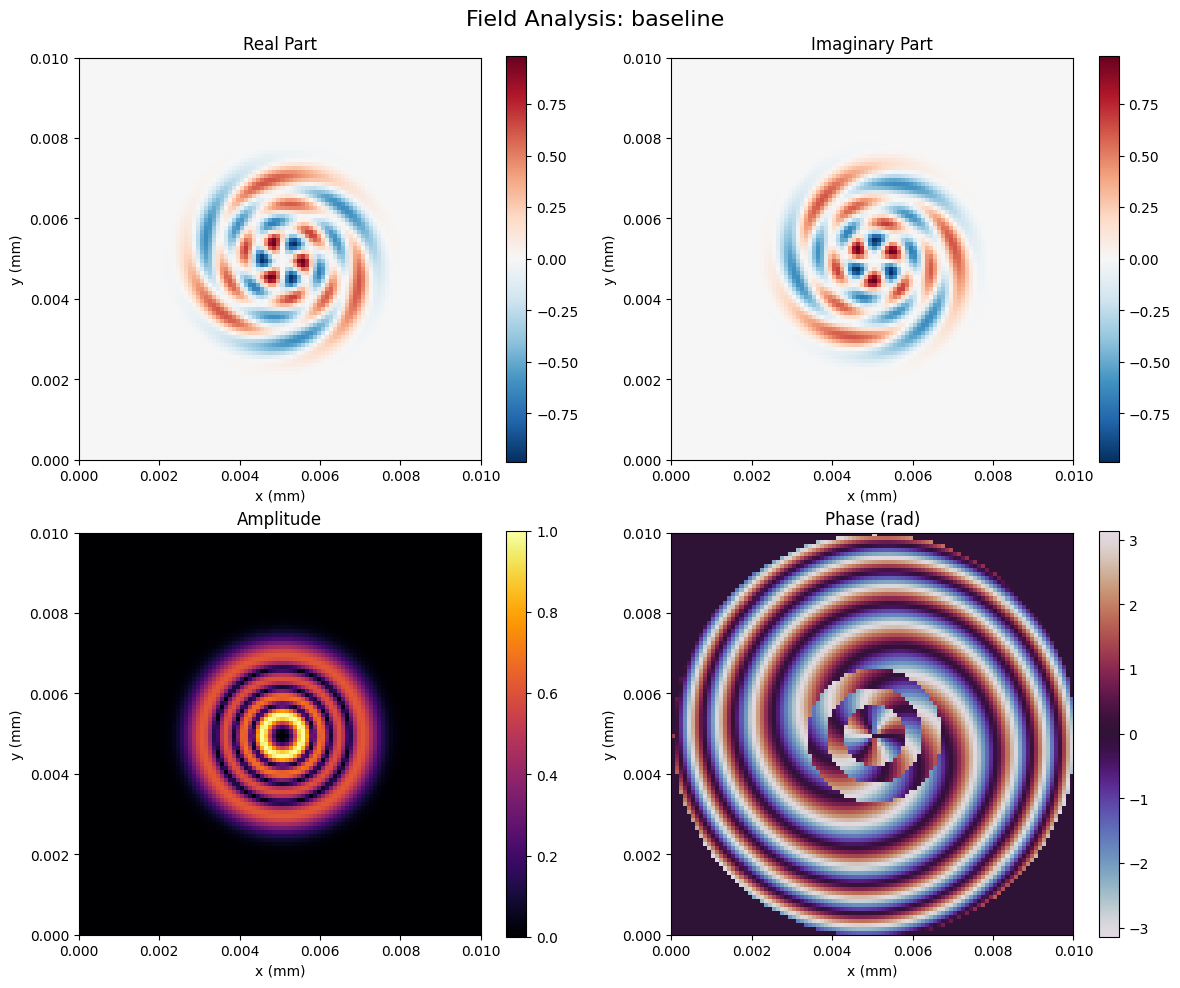

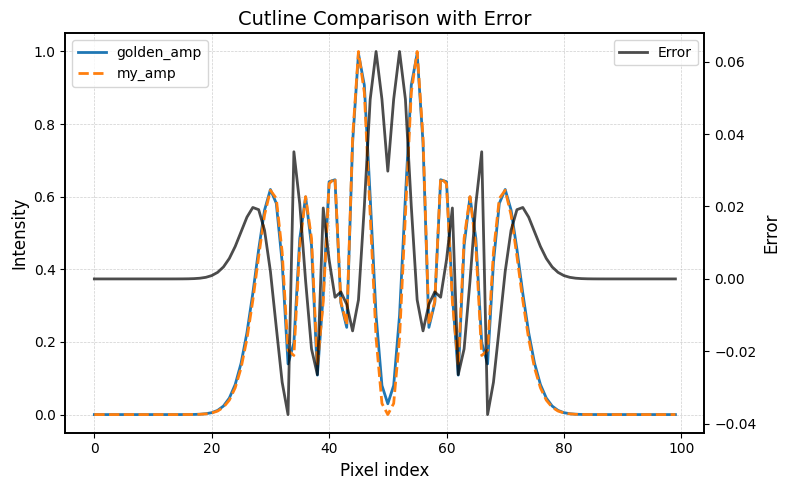

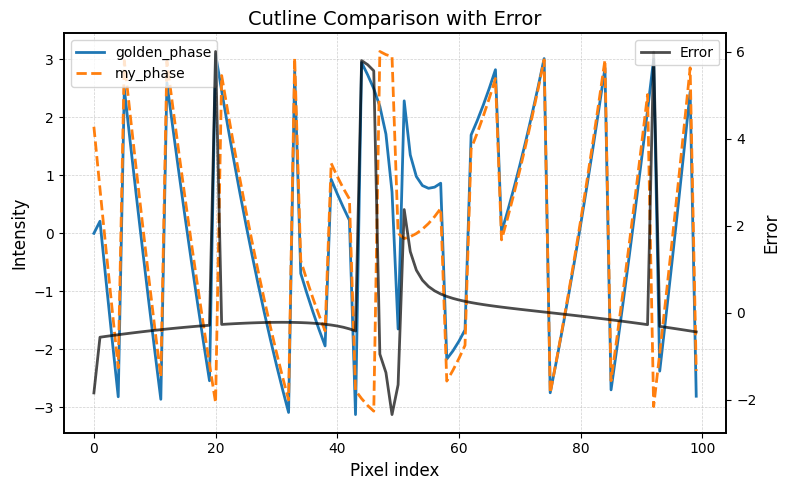

(p=5, l=7, z=1.3963)
w_z=2.0030842034779055 um, rz=1.3962634015954636 um, divergence=82.0701587502936 degree, gouy=122.76156064510921 degree.


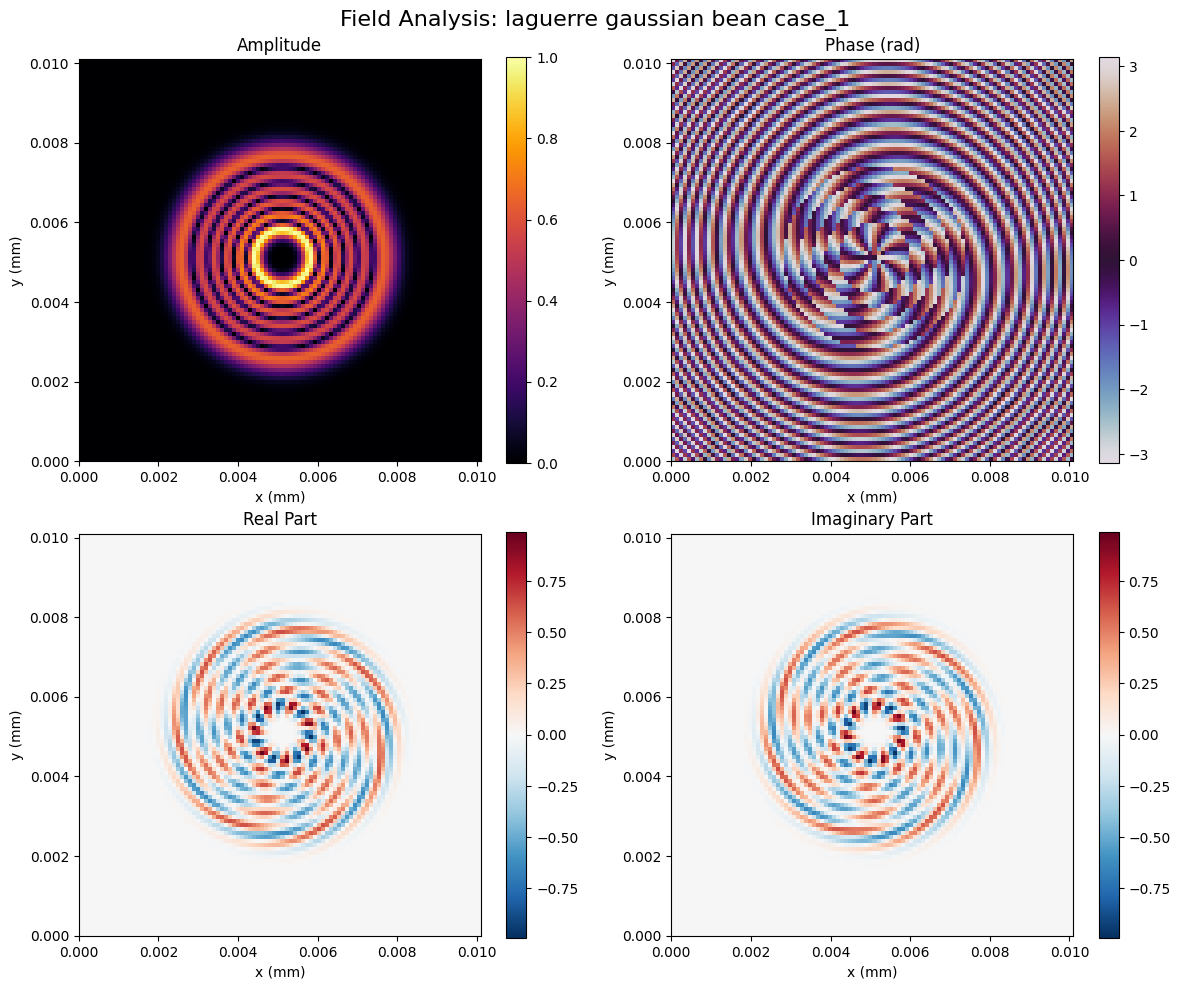

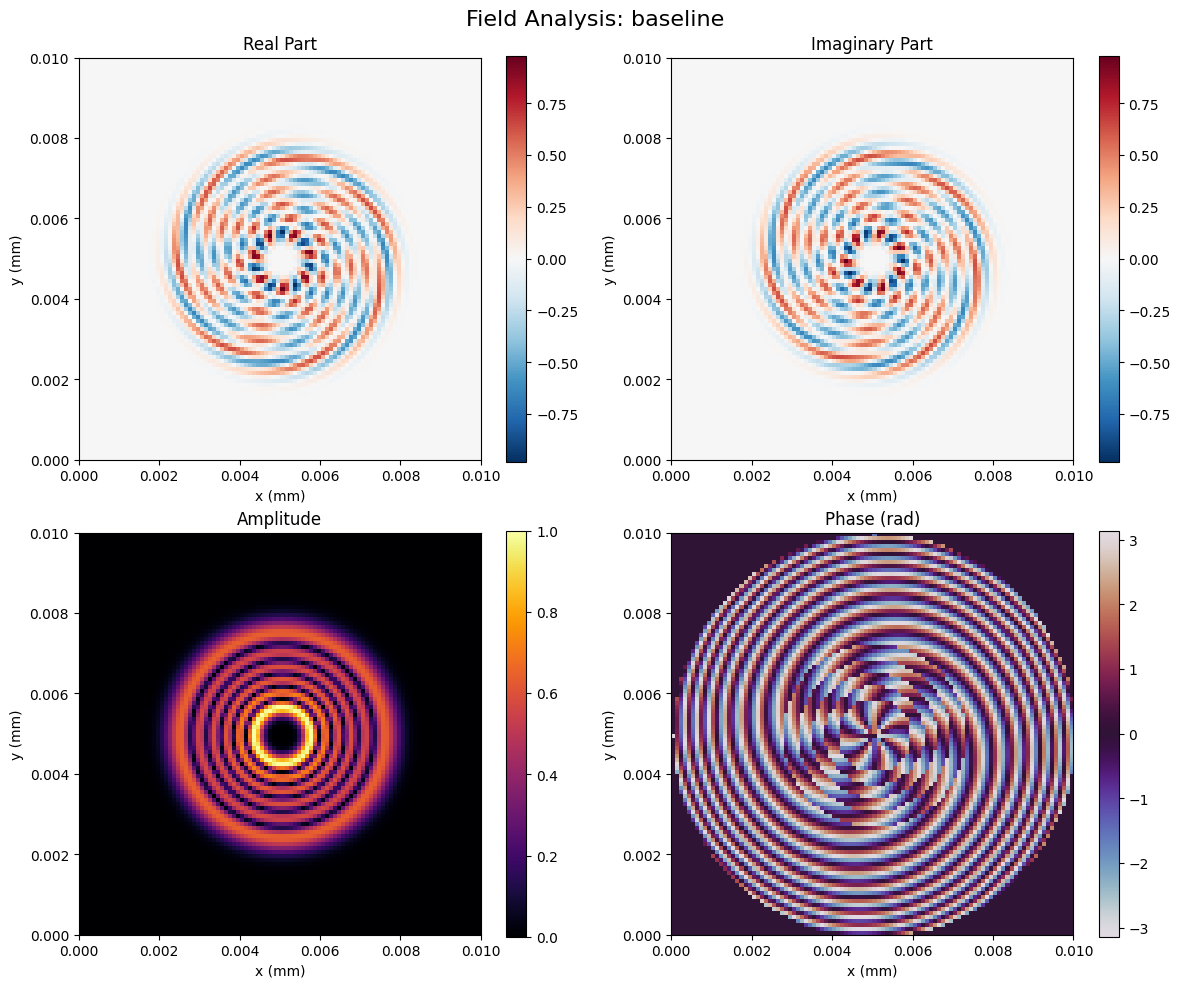

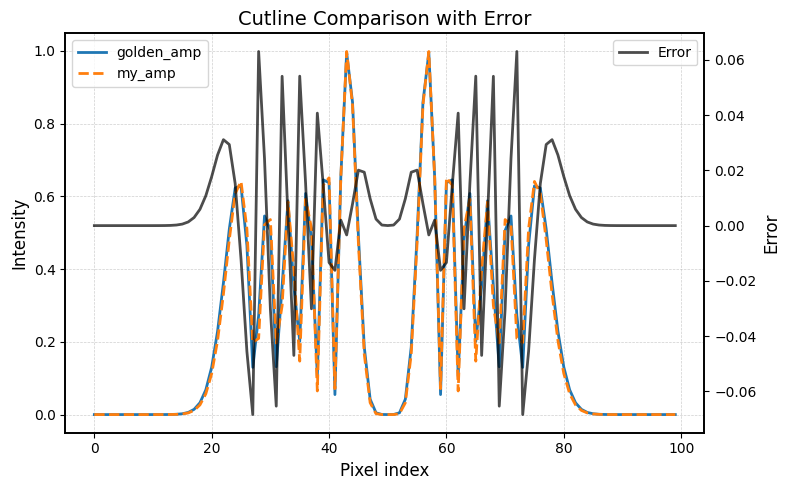

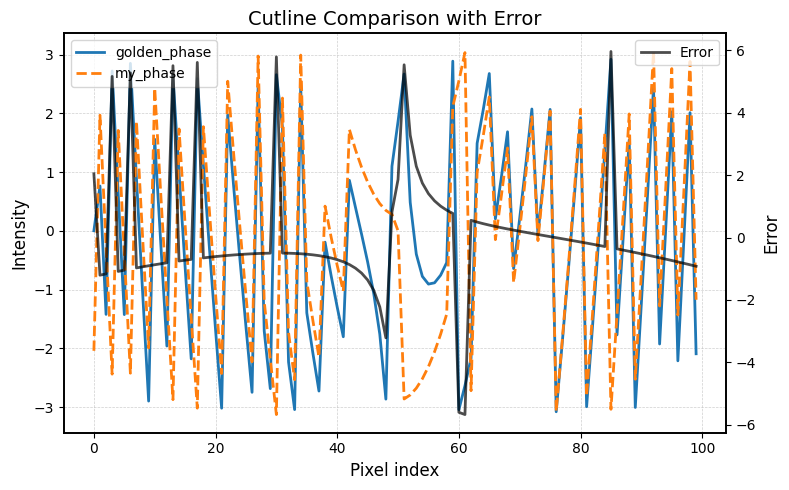

(p=5, l=7, z=0)
w_z=2.0 um, rz=1.3962634015954636 um, divergence=82.0701587502936 degree, gouy=179.99999999999994 degree.


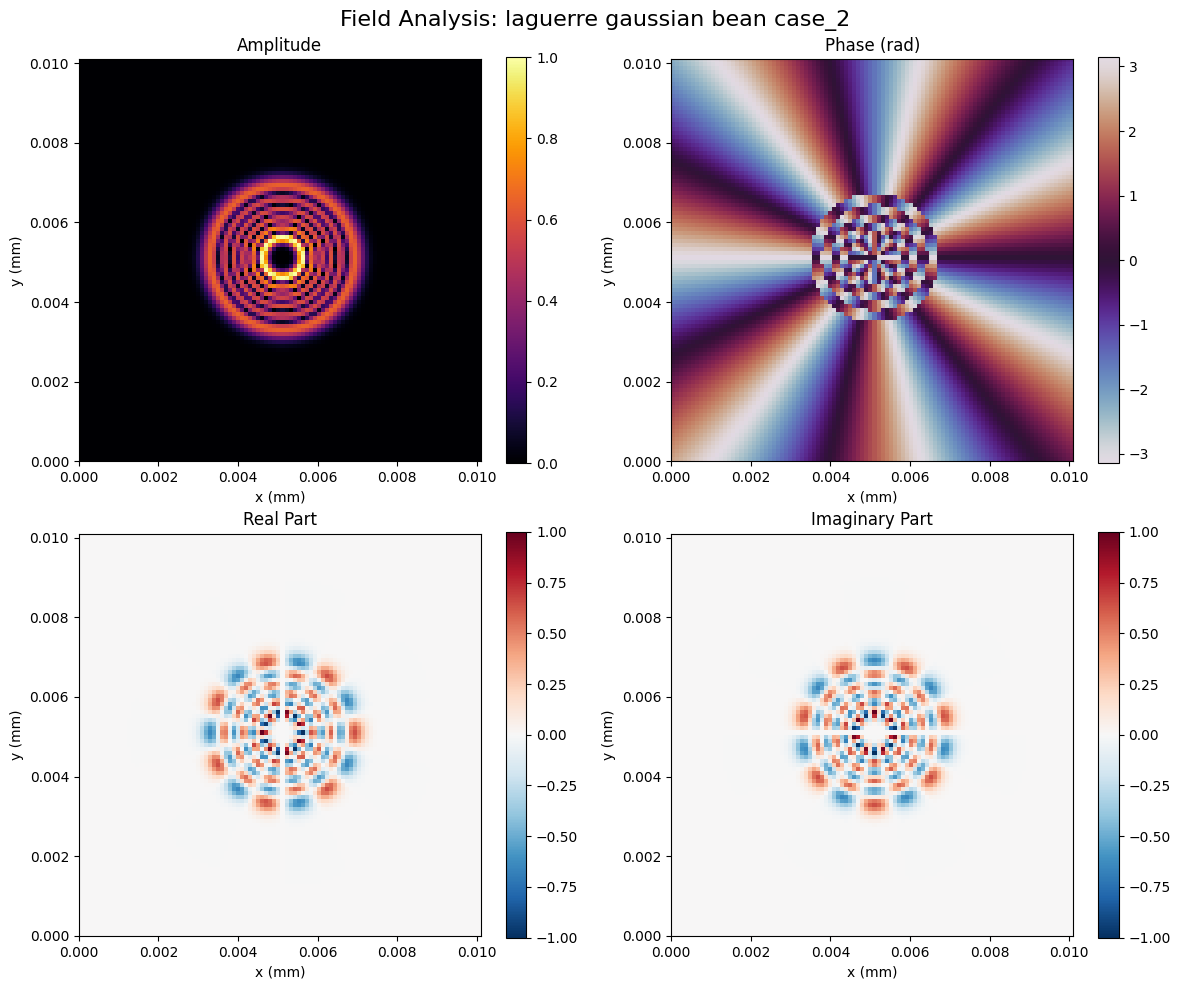

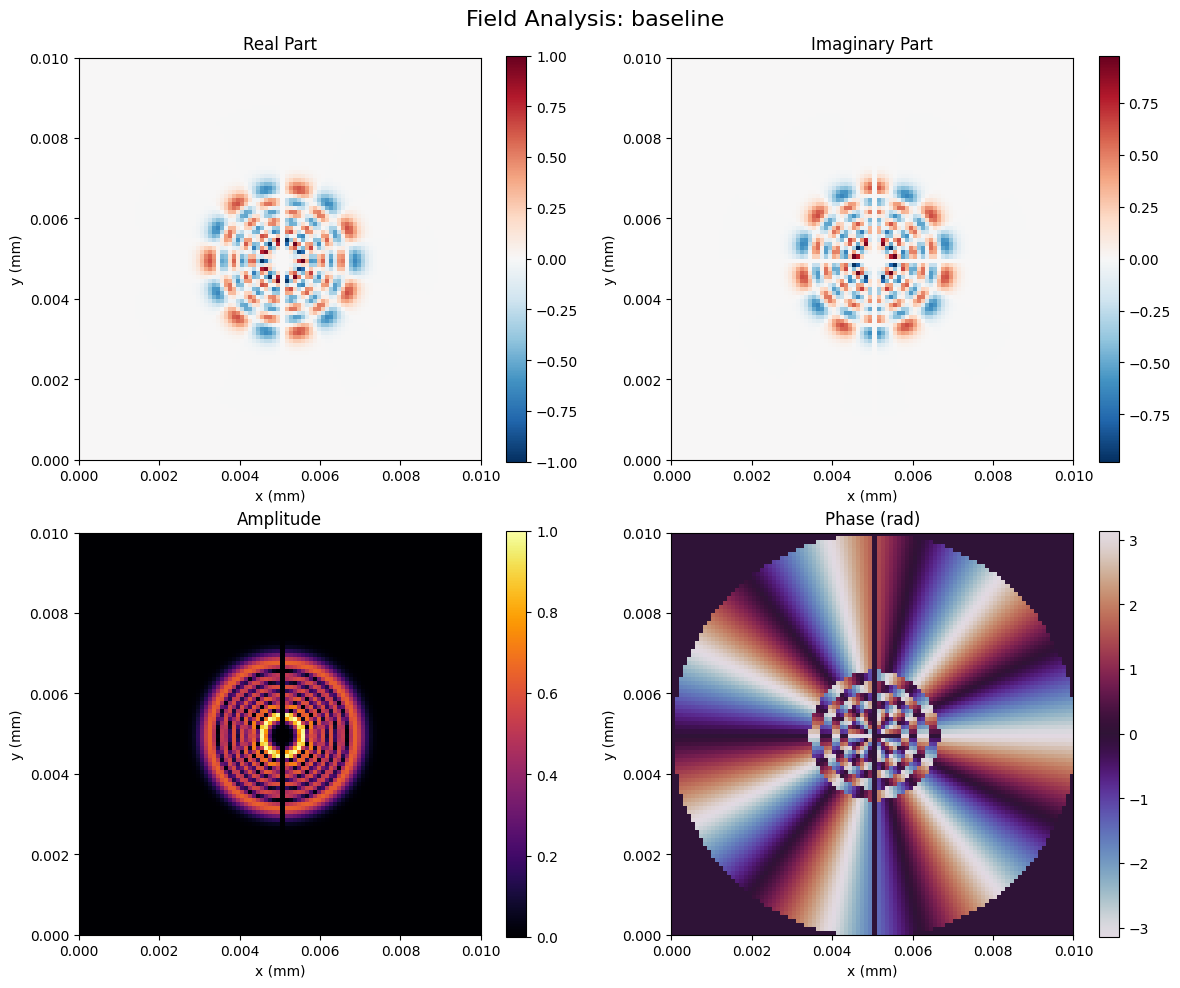

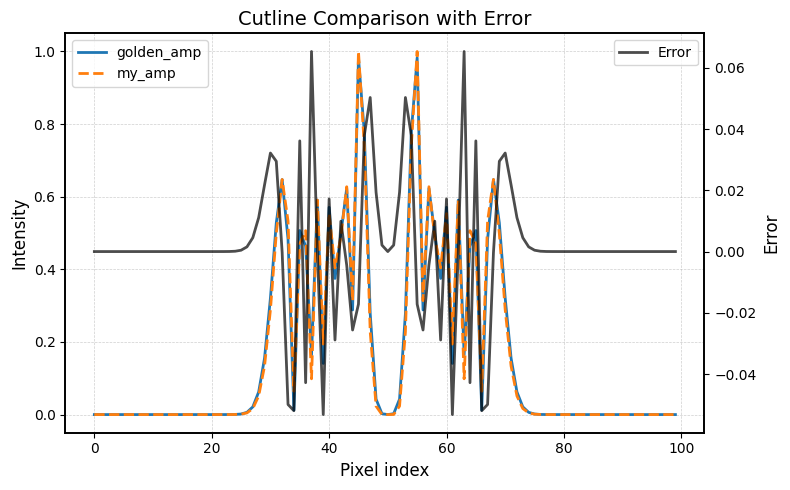

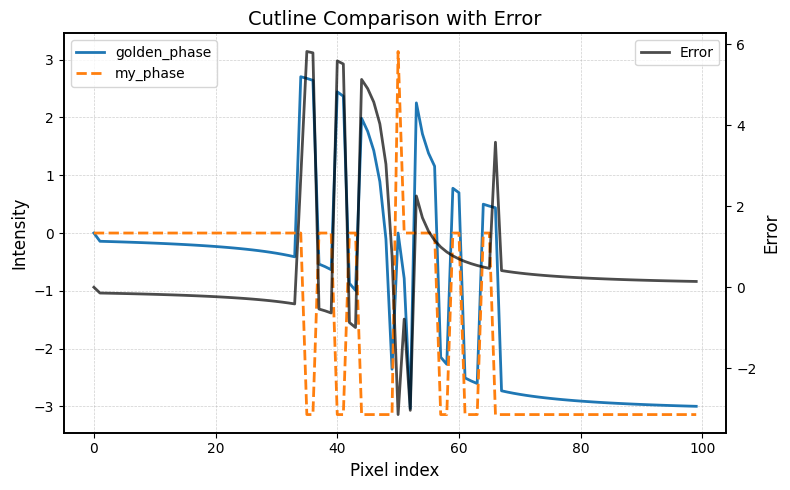

(p=5, l=5, z=1.3)
w_z=2.0026737253038056 um, rz=1.5707963267948966 um, divergence=72.9512522224832 degree, gouy=-47.3760922720348 degree.


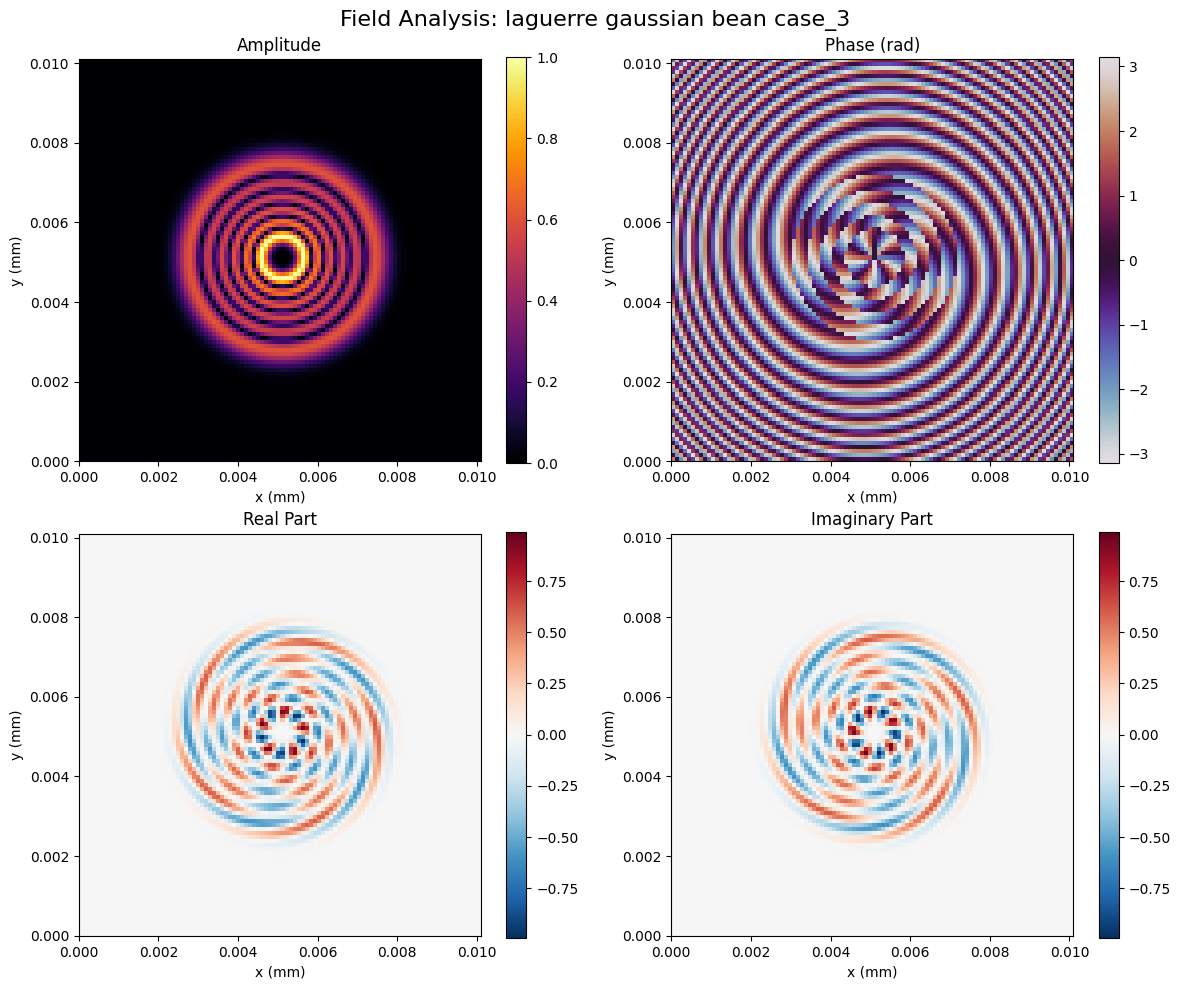

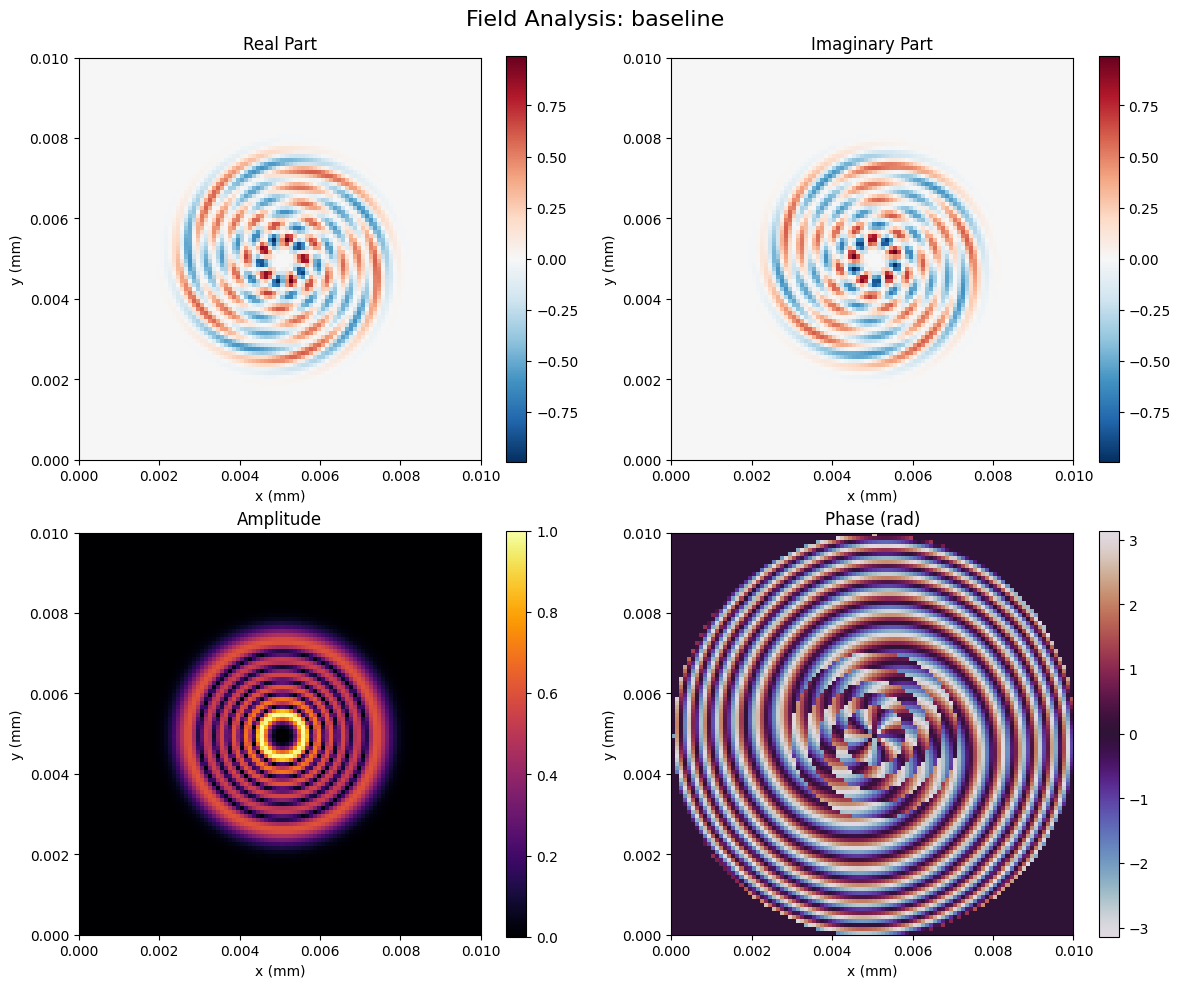

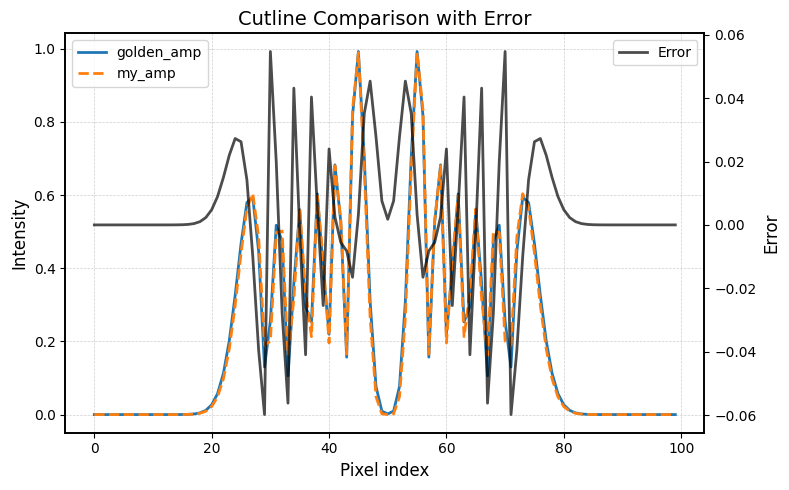

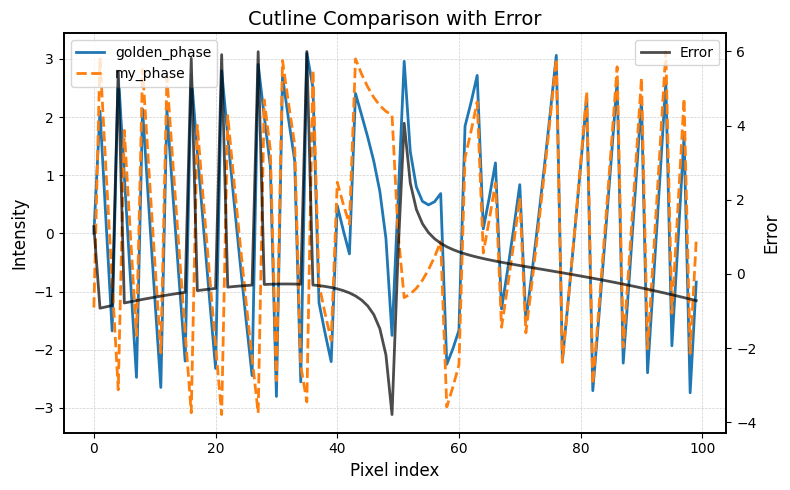

(p=5, l=6, z=0.7)
w_z=2.000775589927328 um, rz=1.478396542865785 um, divergence=77.5107054863884 degree, gouy=62.878264770704845 degree.


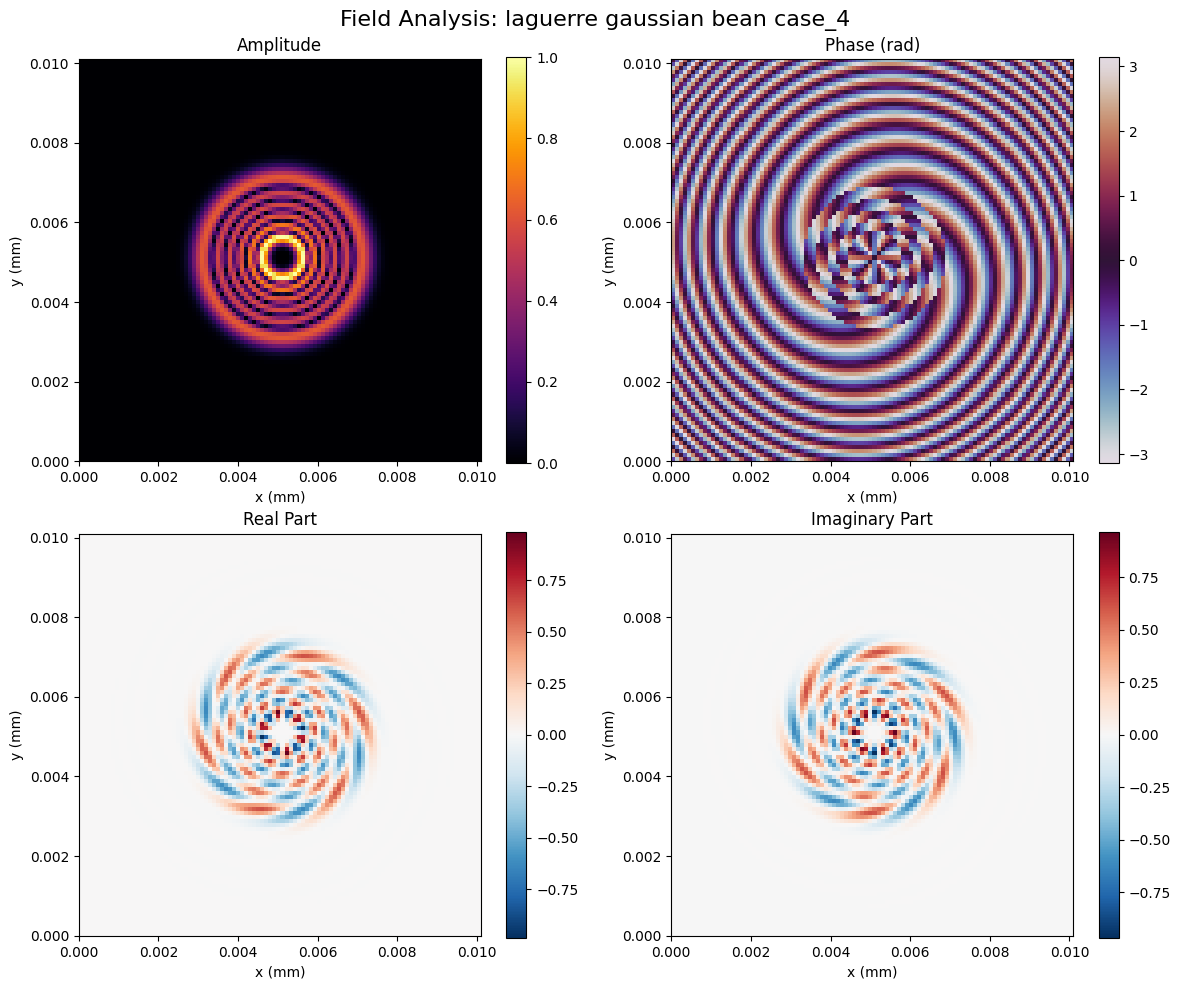

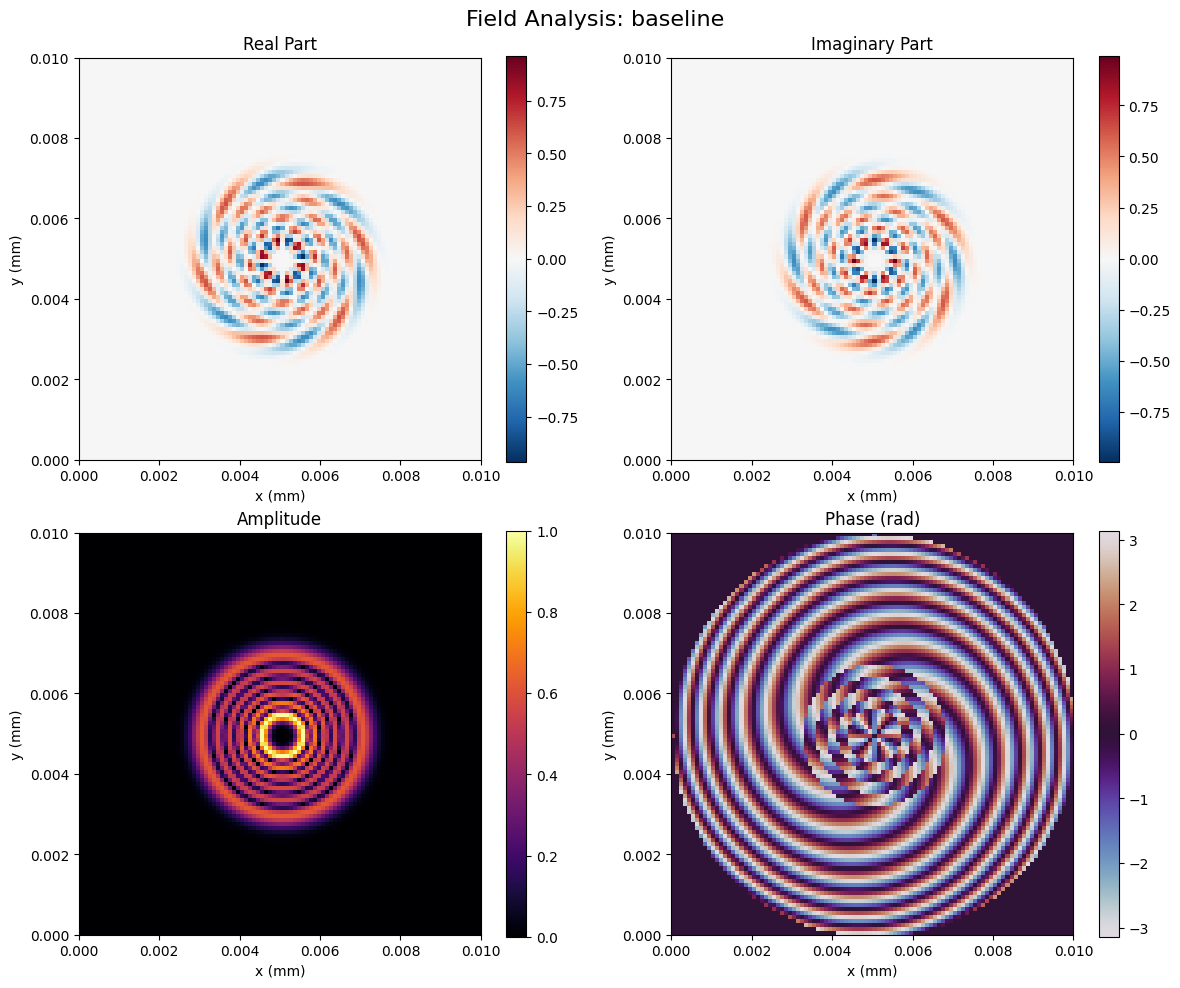

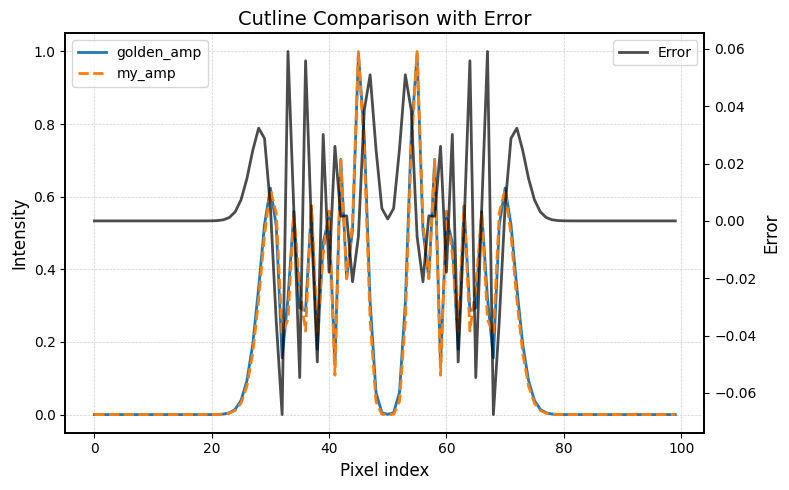

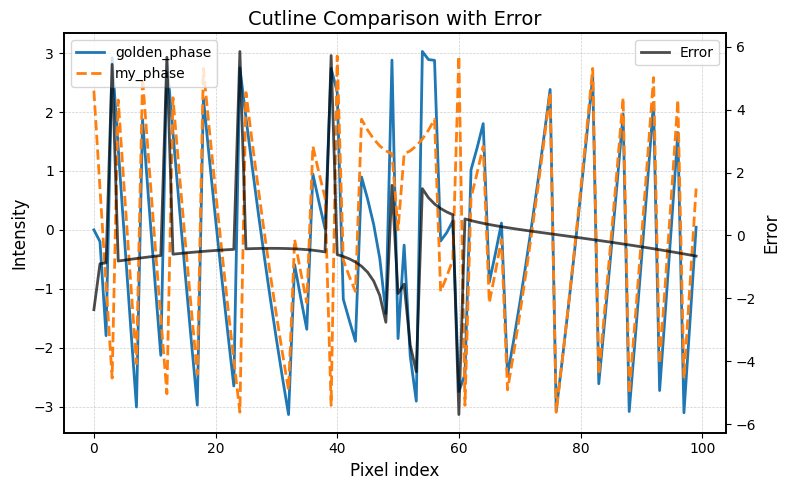

(p=5, l=6, z=1.4)
w_z=2.003100557884248 um, rz=1.478396542865785 um, divergence=77.5107054863884 degree, gouy=35.79852154193536 degree.


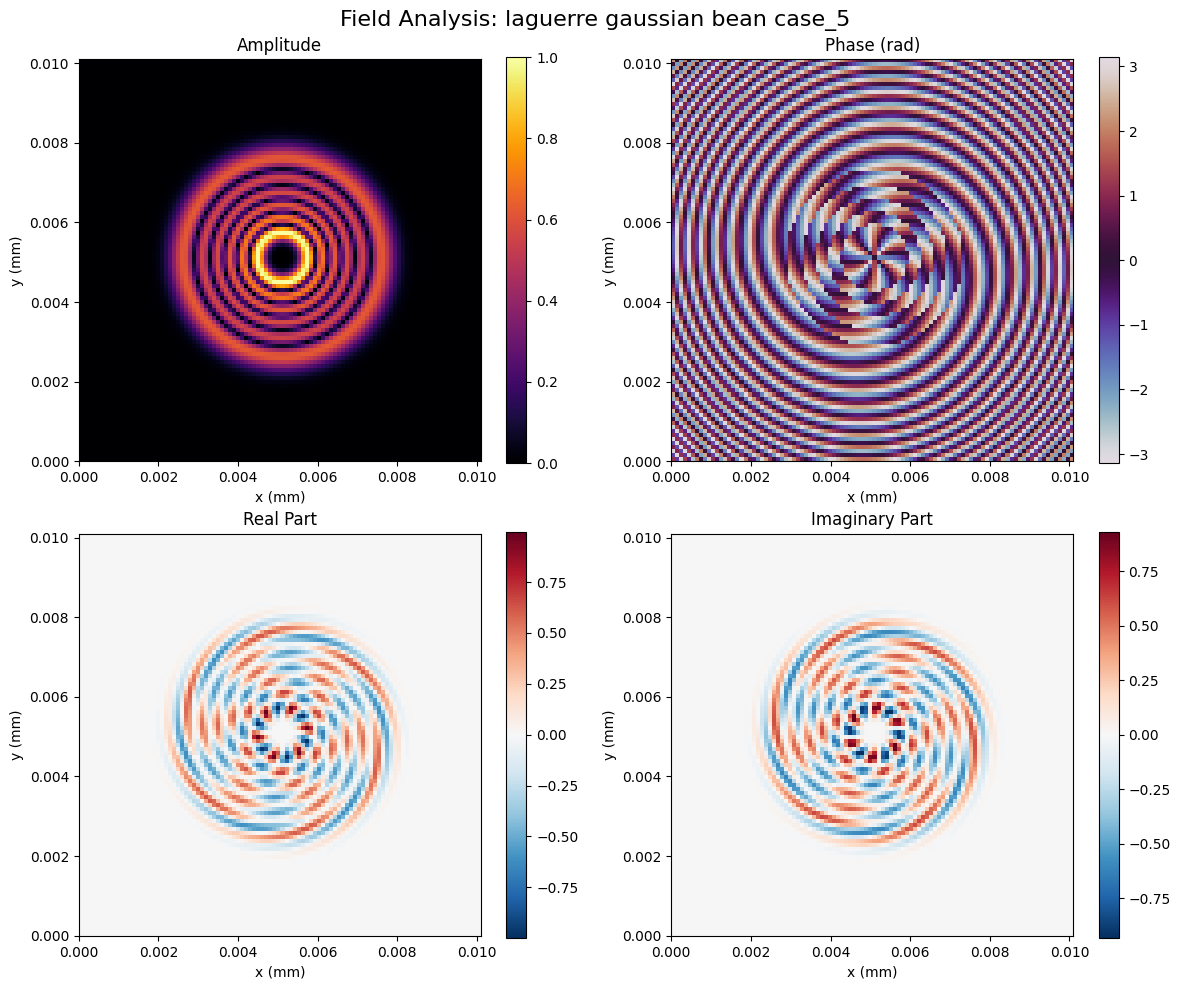

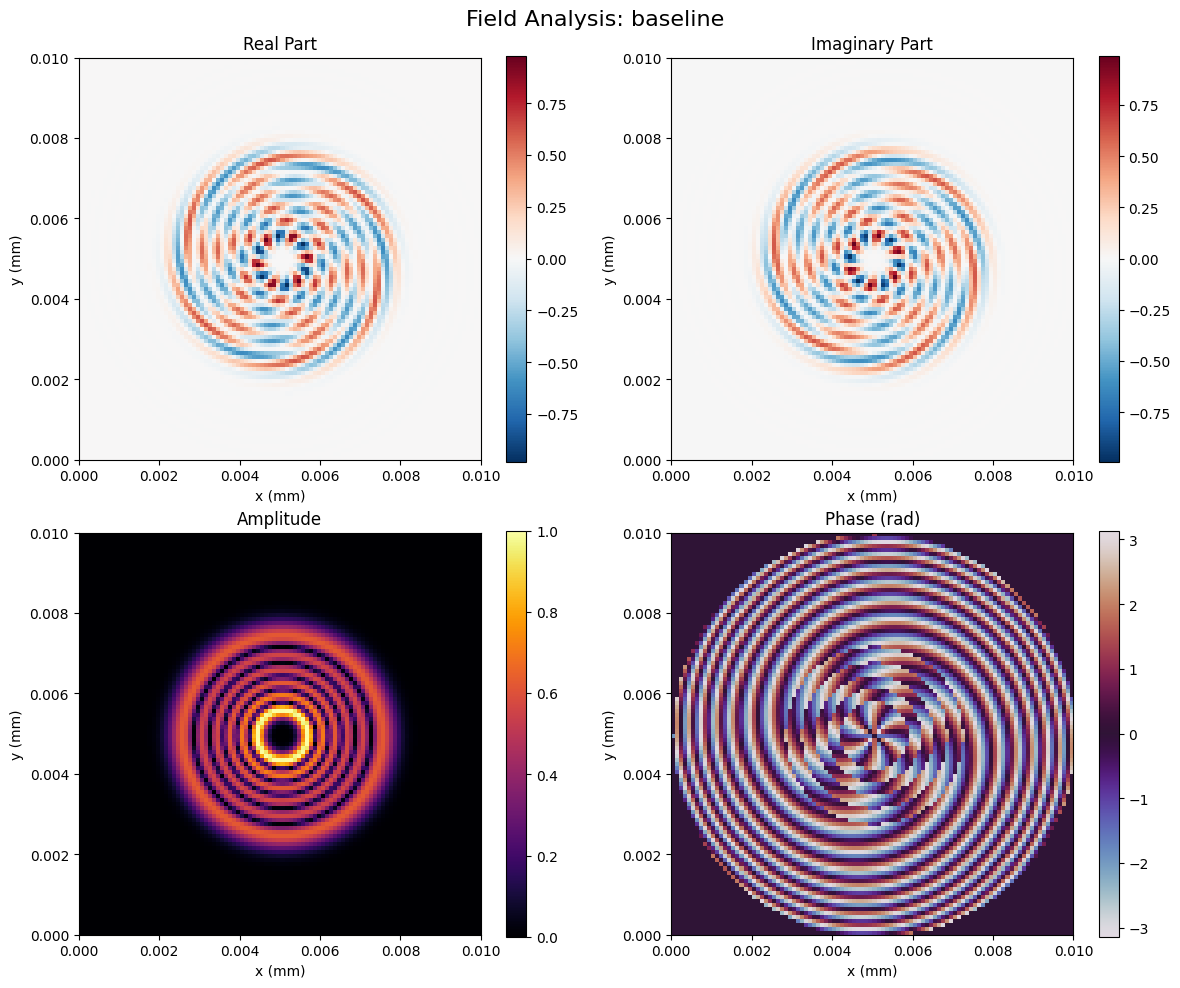

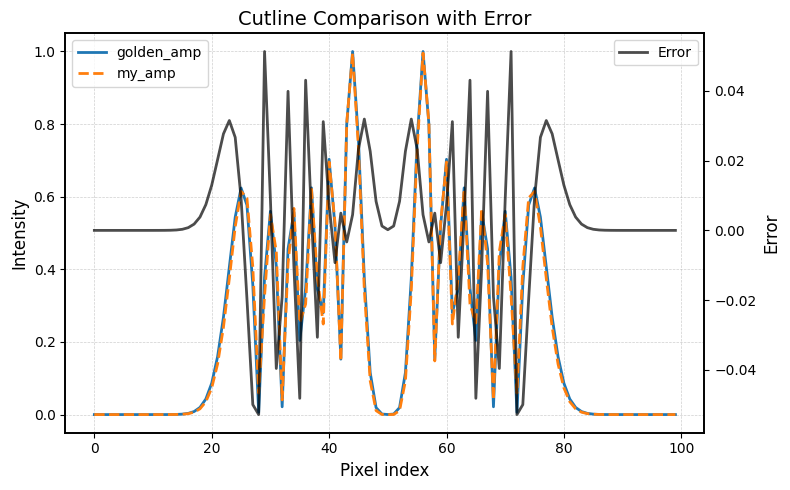

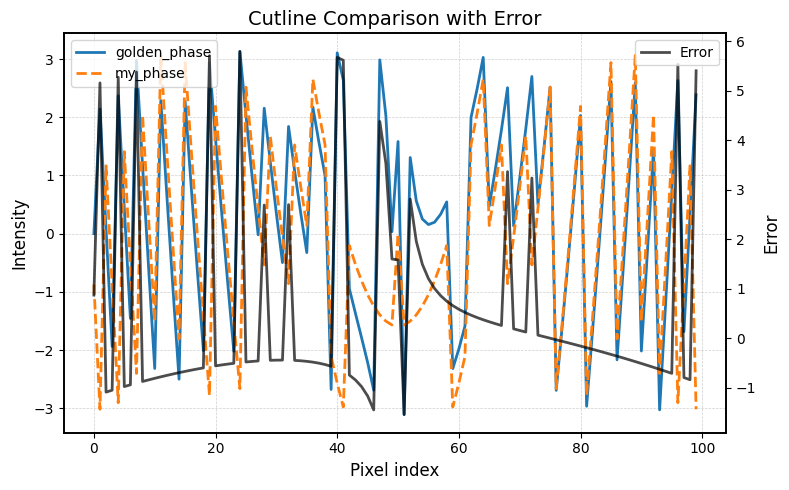

(p=5, l=6, z=1.8)
w_z=2.0051228240902286 um, rz=1.478396542865785 um, divergence=77.5107054863884 degree, gouy=20.359273991620462 degree.


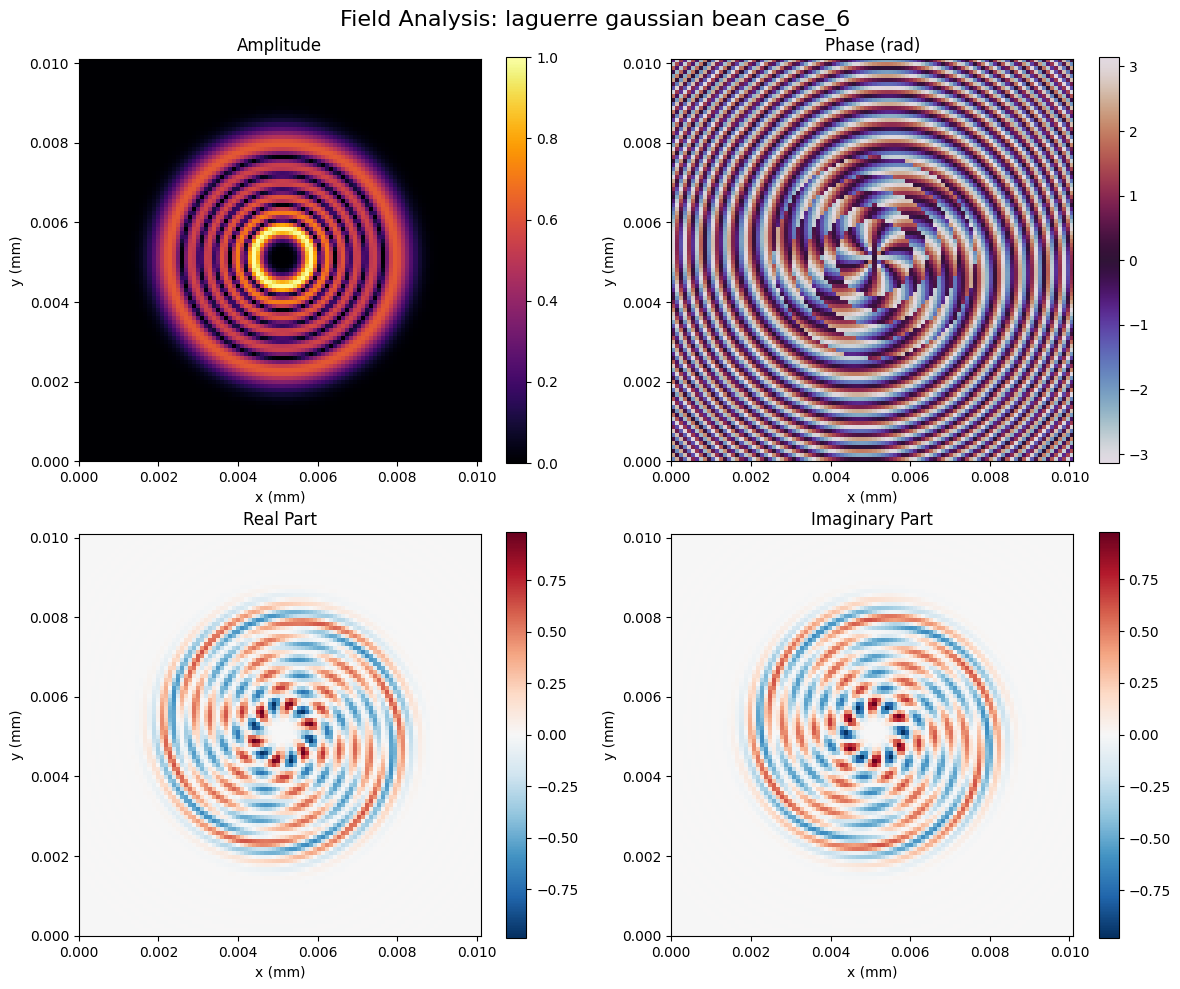

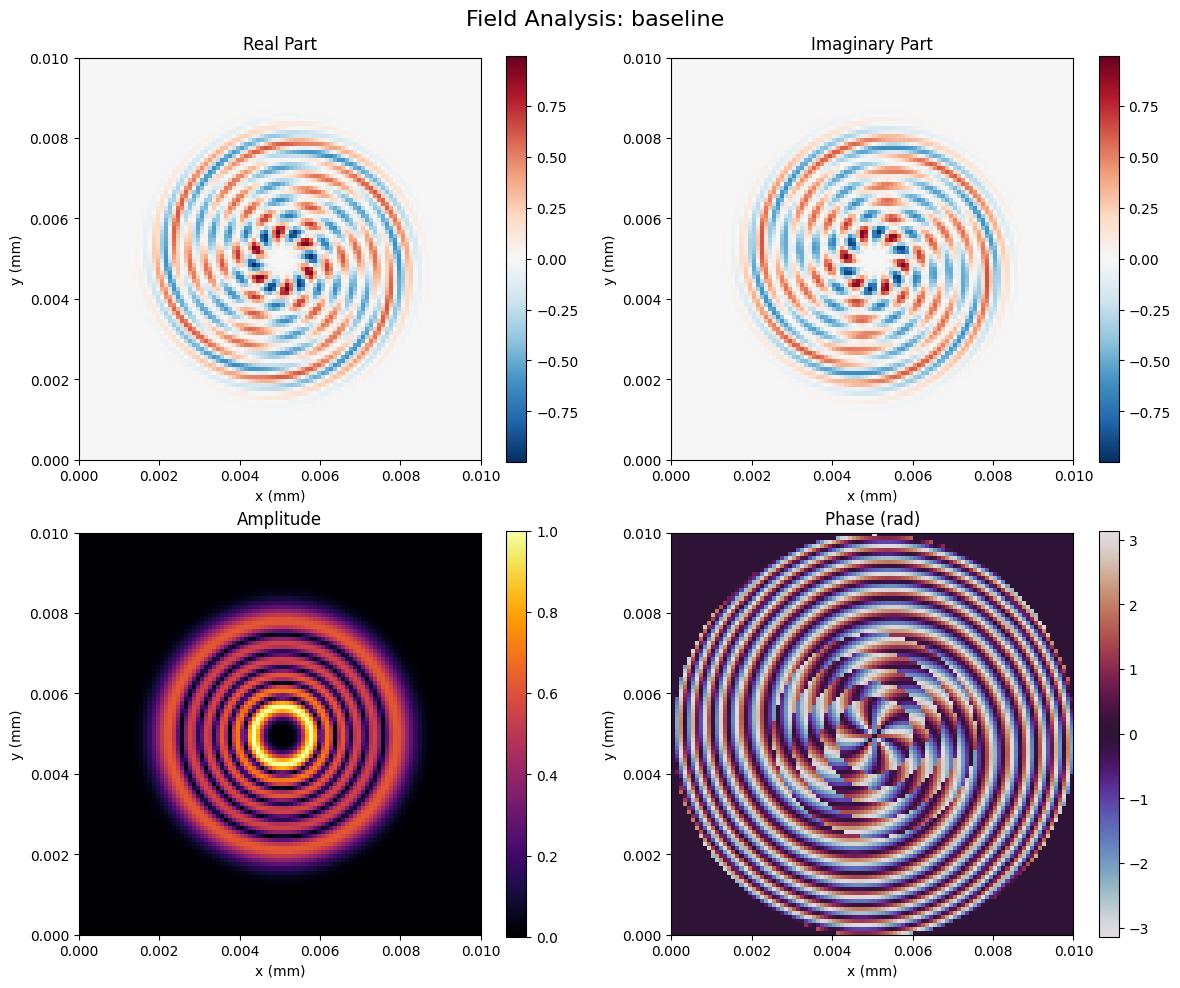

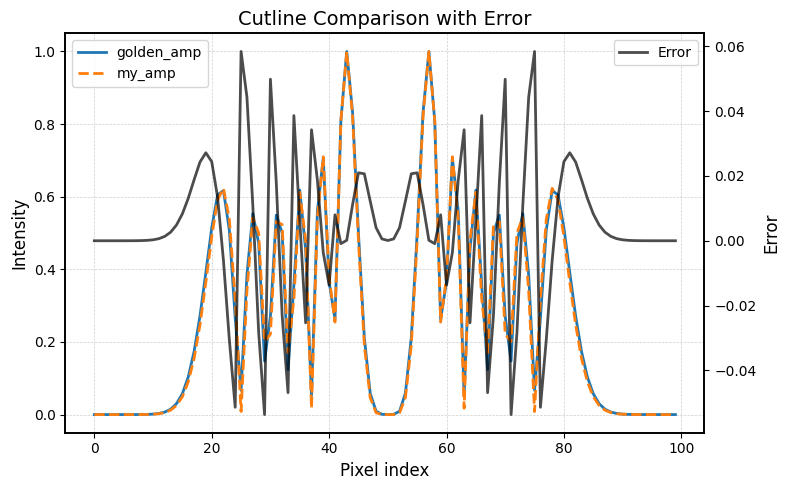

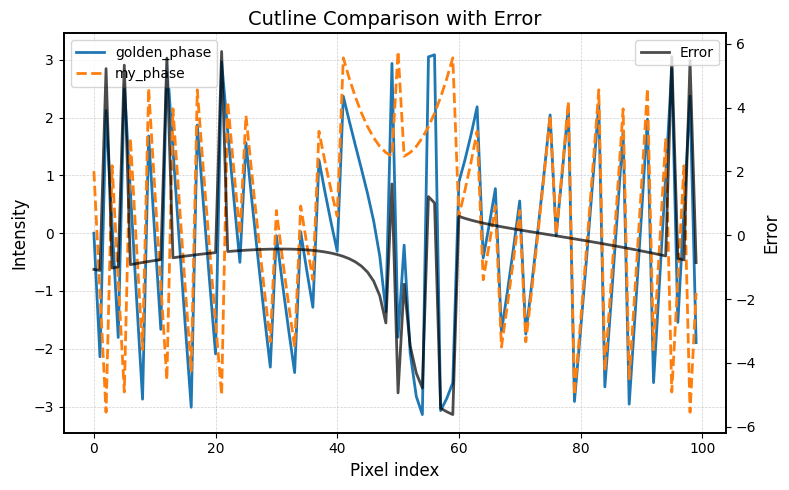

(p=5, l=6, z=1.4784)
w_z=2.0034572356757874 um, rz=1.478396542865785 um, divergence=77.5107054863884 degree, gouy=32.77003520124683 degree.


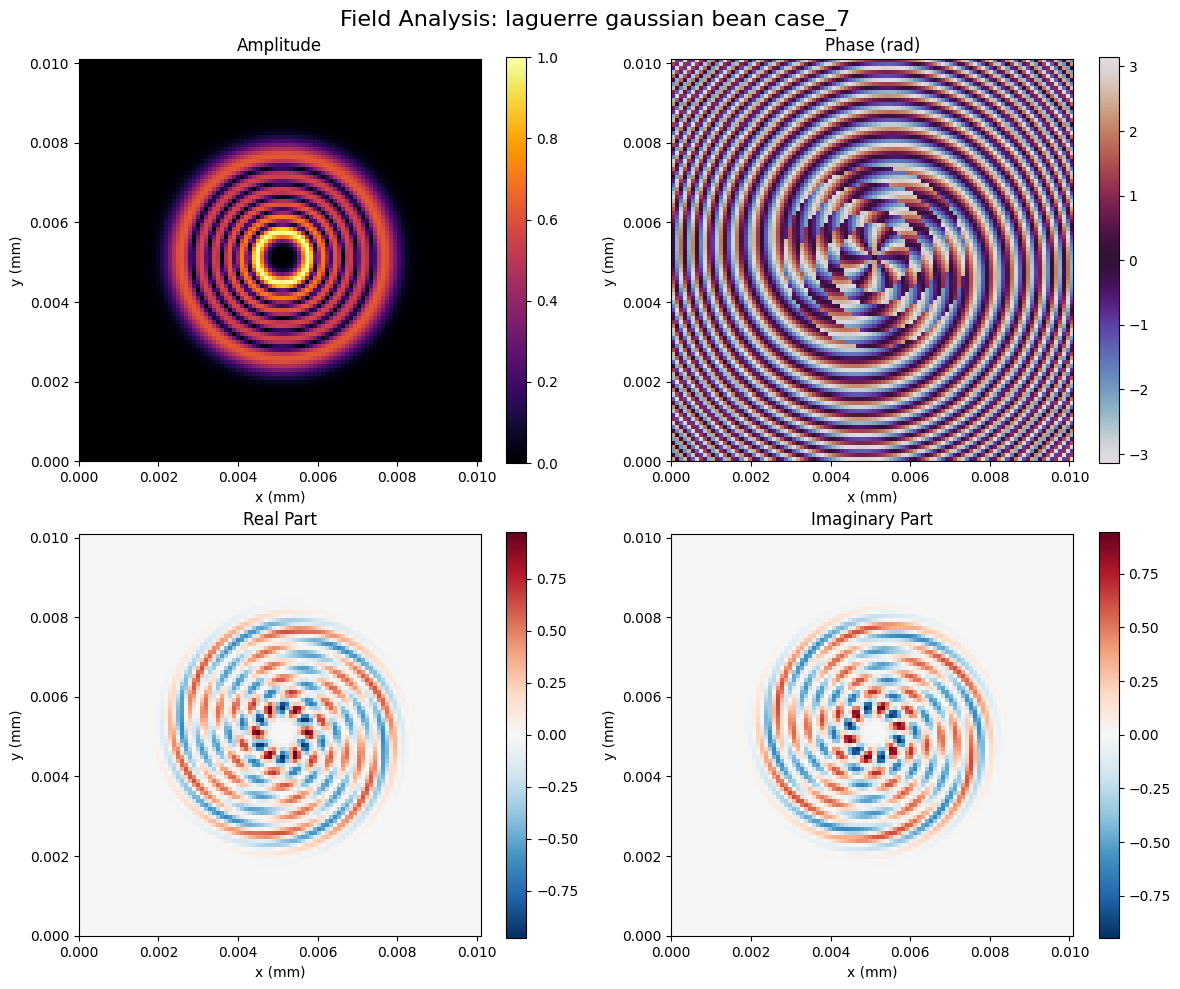

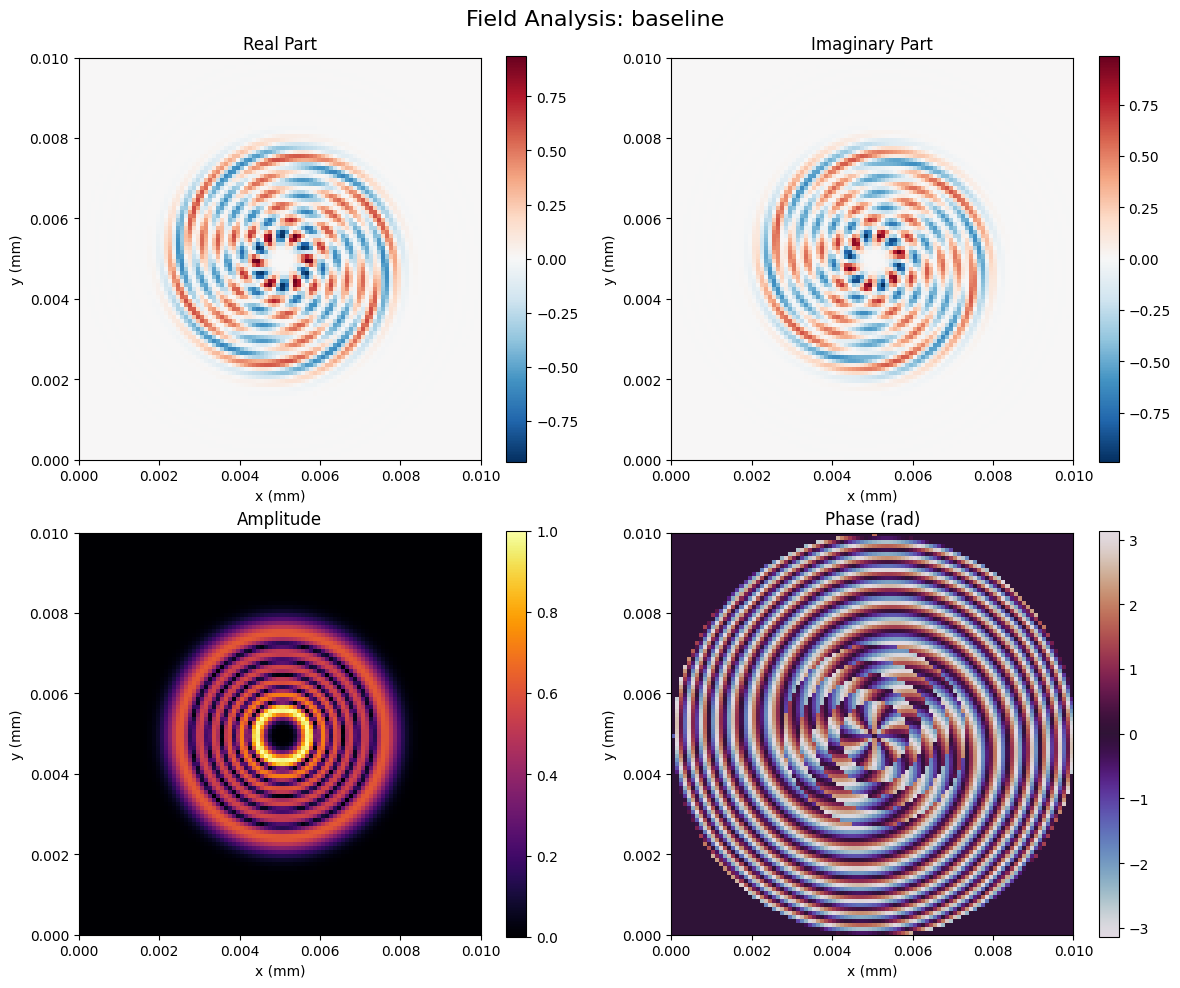

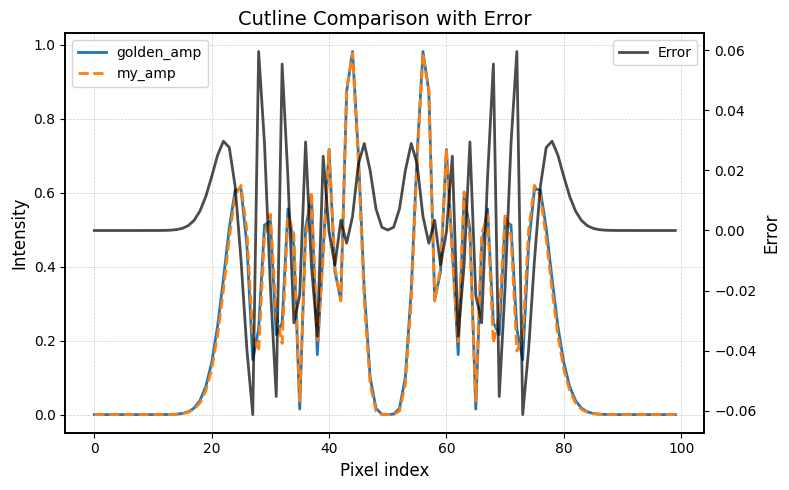

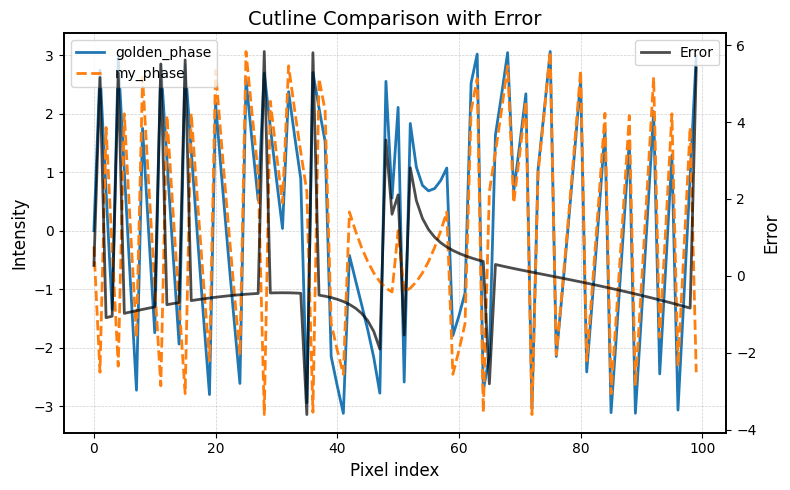

In [59]:
test = [
    [3, 3, 1.3963], [5, 7,  1.3963],[5,7,0], [5,5, 1.3], [5,6,0.7], [5,6, 1.4], 
    [5,6, 1.8], # 超出瑞丽范围之后, 误差显著增大
    [5,6, 1.4784]
]
fix_phase_list = [-2.49429, 0.5594, -np.pi, 0.5613, -0.1422, 0.2920, -2.1058, -0.2245]
print(f"patch phase = {[x/degree for x in fix_phase_list]} degree")

def example(case_index):
    p,l,z = test[case_index]
    baseline = f"{notebook_dir}/golden_data/LG/{case_index}.fin"
    baseline_meta, baseline = parse_file(baseline)
    U, w_z, rz, divergence, gouy = laguerre_gaussian_normalized(X, Y,
                w0=w0,
                z=z,
                wavelength=wavelength,
                p=p, l=l)

    y_index = shape[1]//2  
    # veritical
    angle = -np.angle(U[:, y_index])
    amp   = np.abs(U[:, y_index])
    # horizon
    # angle = np.angle(U[y_index,:])
    # amp   = np.abs(U[y_index,:])

    print_feature = False
    if print_feature:
        print("------------------------------------\n\n")
        feature = find_local_extrema_np(amp)
        for k, minmax in feature.items():
            for index in [d['index'] for d in minmax]:
                print(f"{index}. {amp[index]}, {angle[index]}")

    print(f"(p={p}, l={l}, z={z})\nw_z={w_z} um, rz={rz} um, divergence={divergence/degree} degree, gouy={np.angle(np.exp(1j*gouy))/degree} degree.")

    # fig = show_complex_plot(U, meta, f"laguerre gaussian bean case_{case_index}")
    fig = show_complex_plot(U, meta, f"laguerre gaussian bean case_{case_index}", [[1, 0], [1, 1], [0,0], [0,1]])
    # fig = show_complex_plot(baseline, baseline_meta, "baseline", [[1, 0], [1, 1], [0,0], [0,1]])
    fig = show_complex_plot(baseline, baseline_meta, "baseline")
    a, b = get_cutline(baseline, shape[0]//2), get_cutline(U, shape[0]//2)
    b *= np.exp(1j * fix_phase_list[case_index])
    plot_cutlines_with_error(np.abs(a), np.abs(b), "golden_amp", "my_amp")
    plot_cutlines_with_error(np.angle(a), np.angle(b), "golden_phase", "my_phase")
    # plot_cutlines_with_error(np.angle(a), np.angle(a), "golden_phase", "golden_phase")
    # plot_cutlines_with_error(np.angle(b), np.angle(b), "my_phase", "my_phase")

case_index = -1
if -1 == case_index:
    for case_index in range(len(test)):
        example(case_index)
else:
    example(case_index)

In [60]:
# 搜索固定相位差
# from search import *
# def calc_result(x):
#     return b * np.exp(1j * x)
# target = a
# norminal_list = np.linspace(-np.pi, np.pi, 20000)
# best_param, best_cost = search_best_coef(calc_result, target, norminal_list)
# print(f"搜索结果: 最佳参数={best_param:.4f}, 最小 RMS={best_cost:.6f}")